
# Data Processor For NSUN6 Model Training Data


[EXPLAIN]

The following are adjustable values (best set to 50, 0.6)... 

In [2]:
count_threshold = 50;
NSUN6_cutoff = 0.6;
pre_processed_data = "ubsseq_preprocessed_data.xlsx"


### Imports & Functions


In [1]:
import random
import math
import pandas as pd
import numpy as np
from pyfaidx import Fasta
import matplotlib.pyplot as plt
from matplotlib import colors
import logomaker as lm
import re

Matplotlib is building the font cache; this may take a moment.


In [3]:
def count_iterable(i):
    return sum(1 for e in i)

In [4]:
PATH = '../GenomeData/'
def extract_seq_genome(genome, chrom, start, end, strand = '+'):
    '''
    Usage:
        - If strand == '+', return sequence
        - If strand == '-', return sequence revese complementary
        - With hg38.get_seq(chrom, start, end, rc= strand == '-').seq get correct position of miRNA,
        for mapping result, you should modify by yourself.

    @author: Trung Duc Nguyen
    '''

    if genome == 'hsa':
        genome = 'hg38'

    gene = Fasta(f"{PATH}/{genome}.fa") 
    #hg38.get_seq('chr1', 100009588 + 1, 100009608, rc=False).seq
    return(gene.get_seq(chrom, start+1, end, rc= strand == '-').seq)

In [5]:
def one_hot_encode(seq, nucleotide):
    """
    Given a DNA sequence, return its one-hot encoding for a certain nucleotide
    """
    nucleotides_matcher = {'A':0, 'C':1, 'T':2, 'G':3, 'N':4}
    # Make sure seq has only allowed bases
    allowed = set("ACTGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1,0,0,0,0],
             'C':[0,1,0,0,0],
             'G':[0,0,1,0,0],
             'T':[0,0,0,1,0],
             'N':[0,0,0,0,1]}
    
    # Create array from nucleotide sequence
    vec= np.transpose(np.array([nuc_d[x] for x in seq]))
        
    return ''.join(str(e) for e in  vec[nucleotides_matcher[nucleotide]].tolist())

In [6]:
print(one_hot_encode("AAAATCAGATTAGTTGNAAGACAAGCCAGGTTCCAGACGACGCCGGTCCTACTCCAGAAGCCGGAGTCATTCAAGG", 'N'))

0000000000000000100000000000000000000000000000000000000000000000000000000000



## Data Pre-Processing



### Remove Less-Sampled Genes


In [7]:
data_raw = pd.read_excel(pre_processed_data)
data_raw_shape = data_raw.shape

# Remove data sampled less than threshold
data_sample_count = data_raw[['unconverted', 'converted']].sum(axis=1)
data_significant = data_raw[data_sample_count > count_threshold]
# Remove data with unspecified chromosome
data_significant = data_significant[data_significant['chrom'] != 'MT']
data_significant_shape = data_significant.shape
print(f"Filtered data contains {data_significant_shape[0]} genes out of an initial {data_raw_shape[0]} genes, a {data_significant_shape[0]/data_raw_shape[0]*100:.2f}% retention")

Filtered data contains 1594 genes out of an initial 2140 genes, a 74.49% retention


c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():



### Sort Likely NSUN6 Affected Genes By Delta Ratio


A scatter graph will show the correlation between the control ratio and NSUN6 ratio to help determine which genes should be selected for the positive data set. 

In [8]:
a, b = np.polyfit(data_significant['ratio_siControl'], data_significant['ratio_siNSUN6'], 1)
a = a - NSUN6_cutoff # Not sure how to adjust, come back to this later
ideal_delta_threshold = 1 - a + b
likely_NSUN6 = data_significant[data_significant['delta_ratio'] >= ideal_delta_threshold]
likely_NSUN6_shape = likely_NSUN6.shape
likely_NSUN2 = data_significant[data_significant['delta_ratio'] < ideal_delta_threshold]

### Data clean
likely_NSUN6=likely_NSUN6.drop([
    'gene_type','gene_pos','unconverted','converted','ratio_siControl','ratio_siNSUN6','delta_ratio'
    ], axis=1)
likely_NSUN2=likely_NSUN2.drop([
    'gene_type','gene_pos','unconverted','converted','ratio_siControl','ratio_siNSUN6','delta_ratio'
    ], axis=1)

print(f"Ideal data threshold should be above delta ratio {(ideal_delta_threshold) * 100:.2f}%")
print(f"This threshold includes {likely_NSUN6_shape[0]} samples out of the {data_significant_shape[0]} valid samples, a {likely_NSUN6_shape[0]/data_significant_shape[0]*100:.2f}% retention")

Ideal data threshold should be above delta ratio 67.86%
This threshold includes 228 samples out of the 1594 valid samples, a 14.30% retention


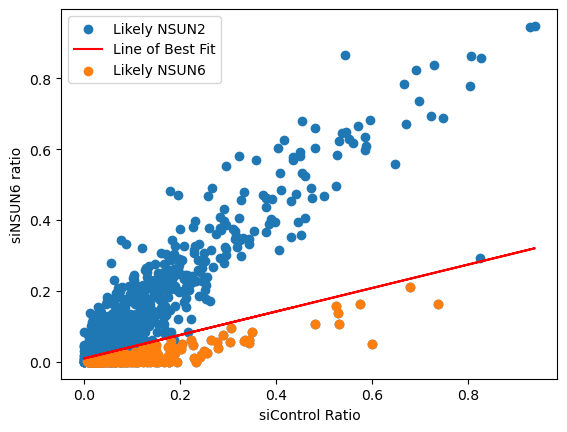

Best fit gradient is 0.33 and y-intercept is 0.01


In [9]:
plt.scatter(data_significant['ratio_siControl'], data_significant['ratio_siNSUN6'], label='Likely NSUN2')
plt.xlabel('siControl Ratio')
plt.ylabel('siNSUN6 ratio')
plt.plot(data_significant['ratio_siControl'], a * np.array(data_significant['ratio_siControl']) + b, color='red', label='Line of Best Fit')
gene_search = data_significant[data_significant['delta_ratio'] > (1-a)]
plt.scatter(gene_search['ratio_siControl'], gene_search['ratio_siNSUN6'], label='Likely NSUN6')
plt.legend()
plt.show()
print(f"Best fit gradient is {a:.2f} and y-intercept is {b:.2f}")


#### Select Negative Data From (Likely) NSUN2 Affected Genes



## Sequence Extraction



### Collecting Sequences From Genome


In [10]:
likely_NSUN6['chrom'] = likely_NSUN6['chrom'].replace(
    [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22, 'X'], 
    ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX'])
likely_NSUN2['chrom'] = likely_NSUN2['chrom'].replace(
    [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22, 'X'], 
    ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX'])

## NSUN6 Data
seq_extract = [[],[],[]];
for ind in likely_NSUN6.index:
    gene = likely_NSUN6['gene_name'][ind]
    chrome = likely_NSUN6['chrom'][ind]
    strand = likely_NSUN6['strand'][ind]
    pos = likely_NSUN6['pos'][ind]
    seq_extract[0].append(extract_seq_genome("hg38", chrome, pos-1-50, pos+50, strand)) #50:50
    seq_extract[1].append(extract_seq_genome("hg38", chrome, pos-1-30, pos+70, strand)) #30:70
    seq_extract[2].append(extract_seq_genome("hg38", chrome, pos-1-70, pos+30, strand)) #70:30
likely_NSUN6_ext = likely_NSUN6.assign(
    seq5050=seq_extract[0], seq3070=seq_extract[1], seq7030=seq_extract[2])
## NSUN2 Data
seq_extract = [[],[],[]];
for ind in likely_NSUN2.index:
    gene = likely_NSUN2['gene_name'][ind]
    chrome = likely_NSUN2['chrom'][ind]
    strand = likely_NSUN2['strand'][ind]
    pos = likely_NSUN2['pos'][ind]
    seq_extract[0].append(extract_seq_genome("hg38", chrome, pos-1-50, pos+50, strand)) #50:50
    seq_extract[1].append(extract_seq_genome("hg38", chrome, pos-1-30, pos+70, strand)) #30:70
    seq_extract[2].append(extract_seq_genome("hg38", chrome, pos-1-70, pos+30, strand)) #70:30
likely_NSUN2_ext = likely_NSUN2.assign(
    seq5050=seq_extract[0], seq3070=seq_extract[1], seq7030=seq_extract[2])


#### Select Negative Data From (Likely) NSUN2 Affected Genes


In [11]:
motif='CTCCA'
Q=re.compile(motif)

Likely_NSUN2_CTCCA_ext = pd.DataFrame(index=range(0),columns=likely_NSUN2_ext.columns)
likely_NSUN2_ext_5050 = likely_NSUN2_ext['seq5050'].to_list()
for i in range (0, len(likely_NSUN2_ext_5050)):
    seq=likely_NSUN2_ext_5050[i]
    motif_occurrence = count_iterable(Q.finditer(seq[45:56]))
    if(motif_occurrence != 0):
        entry = likely_NSUN2_ext.loc[likely_NSUN2_ext['seq5050'] == seq]
        Likely_NSUN2_CTCCA_ext = pd.concat([Likely_NSUN2_CTCCA_ext,entry])
print(Likely_NSUN2_CTCCA_ext.shape)

(76, 7)



### Motif Visualisation With Logos


Generate a sequence logo. To do so we focus on the nucleotides immediately adjacent to the methylated 'C' theoretically in index 50. This value should be in the centre of each extended sequence so we will just take the values from 45 to 56. 


#### Positve Data Set


Text(0, 0.5, 'Information (bits)')

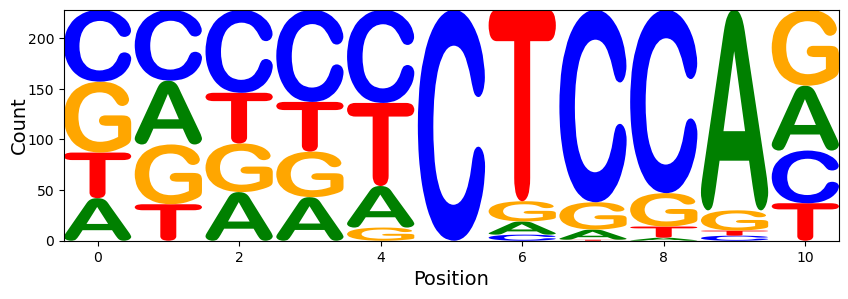

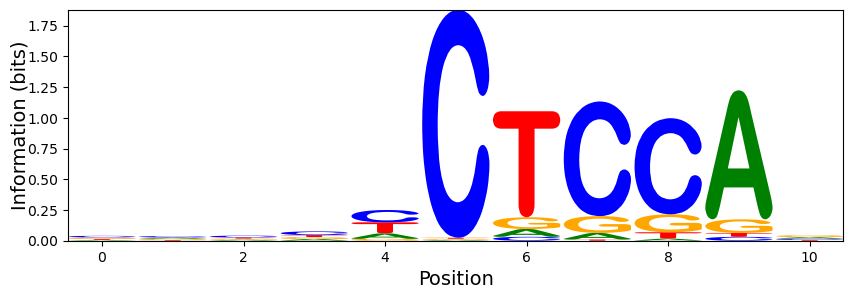

In [12]:
likely_NSUN6_ext_5050 = likely_NSUN6_ext['seq5050'].to_list()
for i in range (0, len(likely_NSUN6_ext_5050)):
    likely_NSUN6_ext_5050[i] = likely_NSUN6_ext_5050[i][45:56]
counts_mat = lm.alignment_to_matrix(likely_NSUN6_ext_5050)

info_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='information')
logo_count = lm.Logo(df=counts_mat, font_name='Arial Rounded MT Bold',figsize=(10,3))
logo_count.ax.set_xlabel('Position',fontsize=14)
logo_count.ax.set_ylabel('Count', labelpad=-1,fontsize=14)
logo_info = lm.Logo(df=info_mat,font_name='Arial Rounded MT Bold',figsize=(10,3))
logo_info.ax.set_xlabel('Position',fontsize=14)
logo_info.ax.set_ylabel('Information (bits)', labelpad=-1,fontsize=14)


#### Negative Data Set


Text(0, 0.5, 'Information (bits)')

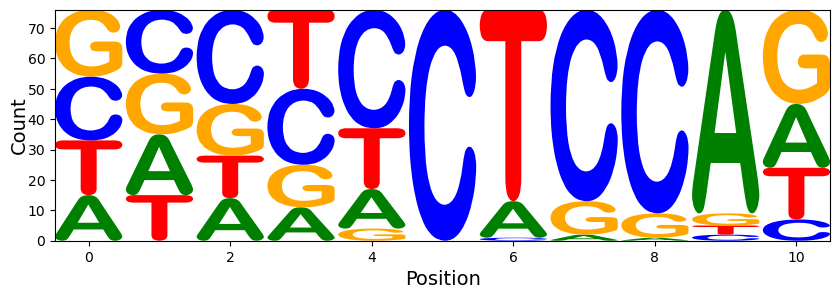

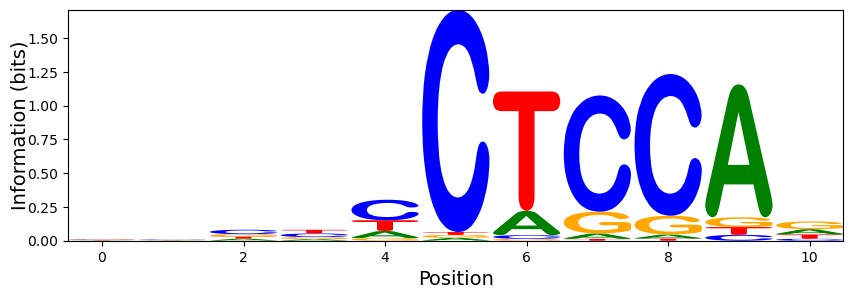

In [31]:
Likely_NSUN2_CTCCA_ext_5050 = Likely_NSUN2_CTCCA_ext['seq5050'].to_list()
for i in range (0, len(Likely_NSUN2_CTCCA_ext_5050)):
    Likely_NSUN2_CTCCA_ext_5050[i] = Likely_NSUN2_CTCCA_ext_5050[i][45:56]
counts_mat = lm.alignment_to_matrix(Likely_NSUN2_CTCCA_ext_5050)

info_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='information')
logo_count = lm.Logo(df=counts_mat, font_name='Arial Rounded MT Bold',figsize=(10,3))
logo_count.ax.set_xlabel('Position',fontsize=14)
logo_count.ax.set_ylabel('Count', labelpad=-1,fontsize=14)
logo_info = lm.Logo(df=info_mat,font_name='Arial Rounded MT Bold',figsize=(10,3))
logo_info.ax.set_xlabel('Position',fontsize=14)
logo_info.ax.set_ylabel('Information (bits)', labelpad=-1,fontsize=14)


## Structure Prediction


In [13]:
### Positive Data
NSUN6_fasta = []
NSUN6_csv = []
NSUN6_enc_csv = []
for ind in likely_NSUN6_ext.index:
    gene_name = likely_NSUN6_ext['gene_name'][ind]
    NSUN6_fasta.append('>%s_5050\n%s' % (gene_name, likely_NSUN6_ext['seq5050'][ind]))
    NSUN6_fasta.append('>%s_3070\n%s' % (gene_name, likely_NSUN6_ext['seq3070'][ind]))
    NSUN6_fasta.append('>%s_7030\n%s' % (gene_name, likely_NSUN6_ext['seq7030'][ind]))
    NSUN6_csv.append('%s,5050,%s' % (gene_name, likely_NSUN6_ext['seq5050'][ind]))
    NSUN6_csv.append('%s,3070,%s' % (gene_name, likely_NSUN6_ext['seq3070'][ind]))
    NSUN6_csv.append('%s,7030,%s' % (gene_name, likely_NSUN6_ext['seq7030'][ind]))

    ### Encoded Sequence (ACGTN)
    NSUN6_enc_csv.append('%s,5050,%s,%s,%s,%s' % (gene_name, one_hot_encode(likely_NSUN6_ext['seq5050'][ind], 'A')
                               , one_hot_encode(likely_NSUN6_ext['seq5050'][ind], 'C')
                               , one_hot_encode(likely_NSUN6_ext['seq5050'][ind], 'G')
                               , one_hot_encode(likely_NSUN6_ext['seq5050'][ind], 'T')
                              ))
    NSUN6_enc_csv.append('%s,3070,%s,%s,%s,%s' % (gene_name,  one_hot_encode(likely_NSUN6_ext['seq3070'][ind], 'A')
                               , one_hot_encode(likely_NSUN6_ext['seq3070'][ind], 'C')
                               , one_hot_encode(likely_NSUN6_ext['seq3070'][ind], 'G')
                               , one_hot_encode(likely_NSUN6_ext['seq3070'][ind], 'T')
                              ))
    NSUN6_enc_csv.append('%s,7030,%s,%s,%s,%s' % (gene_name,  one_hot_encode(likely_NSUN6_ext['seq7030'][ind], 'A')
                               , one_hot_encode(likely_NSUN6_ext['seq7030'][ind], 'C')
                               , one_hot_encode(likely_NSUN6_ext['seq7030'][ind], 'G')
                               , one_hot_encode(likely_NSUN6_ext['seq7030'][ind], 'T')
                               ))
with open('out/NSUN6_ext.fasta', 'w') as file:
     file.write('\n'.join(NSUN6_fasta))
with open('out/NSUN6_ext.csv', 'w') as file:
     file.write('\n'.join(NSUN6_csv))
with open('out/NSUN6_ext_enc.csv', 'w') as file:
     file.write('\n'.join(NSUN6_enc_csv))

### Negative Data
NSUN2_CTCCA_fasta = []
NSUN2_CTCCA_csv = []
NSUN2_CTCCA_enc_csv = []
for ind in Likely_NSUN2_CTCCA_ext.index:
    gene_name = Likely_NSUN2_CTCCA_ext['gene_name'][ind]
    NSUN2_CTCCA_fasta.append('>%s_5050\n%s' % (gene_name, Likely_NSUN2_CTCCA_ext['seq5050'][ind]))
    NSUN2_CTCCA_fasta.append('>%s_3070\n%s' % (gene_name, Likely_NSUN2_CTCCA_ext['seq3070'][ind]))
    NSUN2_CTCCA_fasta.append('>%s_7030\n%s' % (gene_name, Likely_NSUN2_CTCCA_ext['seq7030'][ind]))
    NSUN2_CTCCA_csv.append('%s,5050,%s' % (gene_name, Likely_NSUN2_CTCCA_ext['seq5050'][ind]))
    NSUN2_CTCCA_csv.append('%s,3070,%s' % (gene_name, Likely_NSUN2_CTCCA_ext['seq3070'][ind]))
    NSUN2_CTCCA_csv.append('%s,7030,%s' % (gene_name, Likely_NSUN2_CTCCA_ext['seq7030'][ind]))

    ### Encoded Sequence (ACGT)
    NSUN2_CTCCA_enc_csv.append('%s,5050,%s,%s,%s,%s' % (gene_name, one_hot_encode(Likely_NSUN2_CTCCA_ext['seq5050'][ind], 'A')
                               , one_hot_encode(Likely_NSUN2_CTCCA_ext['seq5050'][ind], 'C')
                               , one_hot_encode(Likely_NSUN2_CTCCA_ext['seq5050'][ind], 'G')
                               , one_hot_encode(Likely_NSUN2_CTCCA_ext['seq5050'][ind], 'T')
                               ))
    NSUN2_CTCCA_enc_csv.append('%s,3070,%s,%s,%s,%s' % (gene_name,  one_hot_encode(Likely_NSUN2_CTCCA_ext['seq3070'][ind], 'A')
                               , one_hot_encode(Likely_NSUN2_CTCCA_ext['seq3070'][ind], 'C')
                               , one_hot_encode(Likely_NSUN2_CTCCA_ext['seq3070'][ind], 'G')
                               , one_hot_encode(Likely_NSUN2_CTCCA_ext['seq3070'][ind], 'T')
                               ))
    NSUN2_CTCCA_enc_csv.append('%s,7030,%s,%s,%s,%s' % (gene_name,  one_hot_encode(Likely_NSUN2_CTCCA_ext['seq7030'][ind], 'A')
                               , one_hot_encode(Likely_NSUN2_CTCCA_ext['seq7030'][ind], 'C')
                               , one_hot_encode(Likely_NSUN2_CTCCA_ext['seq7030'][ind], 'G')
                               , one_hot_encode(Likely_NSUN2_CTCCA_ext['seq7030'][ind], 'T')
                               ))
with open('out/NSUN2_CTCCA_ext.fasta', 'w') as file:
     file.write('\n'.join(NSUN2_CTCCA_fasta))
with open('out/NSUN2_CTCCA_ext.csv', 'w') as file:
     file.write('\n'.join(NSUN2_CTCCA_csv))
with open('out/NSUN2_CTCCA_ext_enc.csv', 'w') as file:
     file.write('\n'.join(NSUN2_CTCCA_enc_csv))

Using the same terminal scripts as last time to get base pairing probabilities


## Final Formatting



### Reformat Base Pairing Probabilities & Sequence To One Hot



#### Reformat Positive


In [6]:
#bpp_data = pd.read_csv(r"out\NSUN6_bpp.csv")
bpp_data = pd.read_csv(r"out\NSUN6_pos_extend_bpp.csv")
current_head = bpp_data.columns
bpp_data.columns = ['pair', 'P', 'gene', 'selection']
bpp_data.loc[len(bpp_data.index)] = current_head

#seq_data = pd.read_csv(r"out/NSUN6_ext.csv")
seq_data = pd.read_csv(r"out/NSUN6_ext.csv")
current_head = seq_data.columns
seq_data.columns = ['gene','selection', 'seq']
seq_data.loc[len(seq_data.index)] = current_head

bpp_3070 = bpp_data[bpp_data['selection'] == 3070].drop('selection', axis=1)
bpp_5050 = bpp_data[bpp_data['selection'] == 5050].drop('selection', axis=1)
bpp_7030 = bpp_data[bpp_data['selection'] == 7030].drop('selection', axis=1)
print(bpp_7030.shape)

## For 5050
seq_5050 = seq_data[seq_data['selection'] == 5050]#.drop_duplicates(subset=['gene'])
all_genes = seq_5050['gene'].to_list()
all_seq = seq_5050['seq'].to_list()
all_pairs = pd.unique(bpp_5050['pair'])

df_pairs_probs = pd.DataFrame(index=range(len(all_genes)),columns=all_pairs)
total_pairs_count = len(all_pairs)

print(len(all_genes))
i = 0;
for gene in all_genes:
    pairs_with_probs = bpp_5050.loc[bpp_5050['gene'] == gene].drop('gene', axis=1)
    for pair in pairs_with_probs['pair']:
        probability = pairs_with_probs[pairs_with_probs['pair']==pair]['P'].to_list()[0]
        df_pairs_probs.loc[i,pair] = probability;
    i = i+1
print(df_pairs_probs.shape)

seq_enc_data = pd.read_csv(r"out/NSUN6_ext_enc.csv")
current_head = seq_enc_data.columns
seq_enc_data.columns = ['gene','selection','A', 'C', 'G', 'T']
seq_enc_data.loc[len(seq_enc_data.index)] = current_head
seq_enc_data = seq_enc_data[seq_enc_data['selection']==5050]
# Concatenate along the first axis (rows)
restruct_name_seq = pd.DataFrame([all_genes, all_seq, seq_enc_data['A'].to_list(), 
                                  seq_enc_data['C'].to_list(), seq_enc_data['G'].to_list(), 
                                  seq_enc_data['T'].to_list()]).T
restruct_name_seq.columns=['gene','seq','A','C','G','T']
final_data = pd.concat([restruct_name_seq,df_pairs_probs], axis=1)
final_data.to_csv('out/Positive_NSUN6_5050.csv', index=False)
print(final_data.shape)

(139382, 3)
227
(227, 4753)
(227, 4759)



#### Reformat Negative


In [24]:
bpp_data = pd.read_csv(r"out\NSUN2_CTCCA_bpp.csv")
current_head = bpp_data.columns
bpp_data.columns = ['pair', 'P', 'gene', 'selection']
bpp_data.loc[len(bpp_data.index)] = current_head

seq_data = pd.read_csv(r"out/NSUN2_CTCCA_ext.csv")
current_head = seq_data.columns
seq_data.columns = ['gene','selection', 'seq']
seq_data.loc[len(seq_data.index)] = current_head

bpp_3070 = bpp_data[bpp_data['selection'] == 3070].drop('selection', axis=1)
bpp_5050 = bpp_data[bpp_data['selection'] == 5050].drop('selection', axis=1)
bpp_7030 = bpp_data[bpp_data['selection'] == 7030].drop('selection', axis=1)


## For 5050
seq_5050 = seq_data[seq_data['selection'] == 5050].drop_duplicates(subset=['gene'])
all_genes = seq_5050['gene'].to_list()
all_seq = seq_5050['seq'].to_list()
all_pairs = pd.unique(bpp_5050['pair'])

df_pairs_probs = pd.DataFrame(index=range(len(all_genes)),columns=all_pairs)
total_pairs_count = len(all_pairs)

i = 0;
for gene in all_genes:
    pairs_with_probs = bpp_5050.loc[bpp_5050['gene'] == gene].drop('gene', axis=1)
    for pair in pairs_with_probs['pair']:
        probability = pairs_with_probs[pairs_with_probs['pair']==pair]['P'].to_list()[0]
        df_pairs_probs.loc[i,pair] = probability;
    i = i+1
print(df_pairs_probs.shape)


seq_enc_data = pd.read_csv(r"out/NSUN2_CTCCA_ext_enc.csv")
current_head = seq_enc_data.columns
seq_enc_data.columns = ['gene','selection','A', 'C', 'G', 'T']
seq_enc_data.loc[len(seq_enc_data.index)] = current_head
seq_enc_data = seq_enc_data[seq_enc_data['selection']==5050]
print(seq_enc_data.shape)
# Concatenate along the first axis (rows)
restruct_name_seq = pd.DataFrame([all_genes, all_seq, seq_enc_data['A'].to_list(), 
                                  seq_enc_data['C'].to_list(), seq_enc_data['G'].to_list(), 
                                  seq_enc_data['T'].to_list()]).T
restruct_name_seq.columns=['gene','seq','A','C','G','T']
final_data = pd.concat([restruct_name_seq,df_pairs_probs], axis=1)
final_data.to_csv('out/Negative_NSUN6_5050.csv', index=False)

(75, 4753)
(75, 6)
